In [1]:
import os
os.chdir("../")

# Set R environment variables using the conda environment path
r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
os.environ['R_HOME'] = r_home
os.environ['R_LIBS'] = f"{r_home}/library"
os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from model_utils.vital_raw_clip import *
print("using device: ", device)

Random seed set to 333
using device:  cuda


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testclip'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# text_config['split'] = True
# text_config['demo']['gre'] = True
# text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col_ls = ['cl_event', 'ts_description', 'demo'],#], 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother'],
    model_name = model_name,
    downsample = True,
    downsample_size = 1000,
    embedded_dim = 128,
    batch_size = 2048, # Data loader settings
    patience = 50, # Training settings
    num_saves = 150,
    num_epochs = 10,
    init_lr = 1e-5,
    text_config = text_config,
    **{'3d': True}  # Add this line
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 141 tasks      | elapsed:    4.8s
[Parallel(n_jobs=36)]: Done 1017 tasks      | elapsed:    6.9s
[Parallel(n_jobs=36)]: Done 2411 tasks      | elapsed:   10.7s
[Parallel(n_jobs=36)]: Done 4136 tasks      | elapsed:   13.9s
[Parallel(n_jobs=36)]: Done 10080 tasks      | elapsed:   18.1s
[Parallel(n_jobs=36)]: Done 20480 tasks      | elapsed:   24.8s
[Parallel(n_jobs=36)]: Done 32480 tasks      | elapsed:   32.5s
[Parallel(n_jobs=36)]: Done 46080 tasks      | elapsed:   41.3s
[Parallel(n_jobs=36)]: Done 61280 tasks      | elapsed:   51.3s
[Parallel(n_jobs=36)]: Done 65353 out of 65353 | elapsed:   54.3s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.    Moderate variability.  Very low amount of consecutive increases. Very high amount of consecutive unchanging values. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 1800 tasks      | elapsed:    1.3s
[Parallel(n_jobs=36)]: Done 4600 tasks      | elapsed:    3.2s
[Parallel(n_jobs=36)]: Done 8200 tasks      | elapsed:    5.6s
[Parallel(n_jobs=36)]: Done 12600 tasks      | elapsed:    8.6s
[Parallel(n_jobs=36)]: Done 17800 tasks      | elapsed:   12.0s
[Parallel(n_jobs=36)]: Done 23800 tasks      | elapsed:   16.1s
[Parallel(n_jobs=36)]: Done 30600 tasks      | elapsed:   20.8s
[Parallel(n_jobs=36)]: Done 38200 tasks      | elapsed:   25.9s
[Parallel(n_jobs=36)]: Done 46600 tasks      | elapsed:   31.6s
[Parallel(n_jobs=36)]: Done 55800 tasks      | elapsed:   37.8s
[Parallel(n_jobs=36)]: Done 61570 out of 61570 | elapsed:   41.6s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.    High variability.  Low amount of consecutive increases. Very high amount of consecutive unchanging values. 
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


/home/jq2uw/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


## Customize VITAL Model

In [5]:
# # for testing purposes way 1
# %load_ext autoreload
# %autoreload 1
# %aimport model_utils.vital_raw_clip

# way 2 if way 1 not working
%load_ext autoreload
%autoreload 2
import importlib
import model_utils.vital_raw_clip
importlib.reload(model_utils.vital_raw_clip)

<module 'model_utils.vital_raw_clip' from '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/script/VITAL/model_utils/vital_raw_clip.py'>

In [6]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-10,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    # torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─MultiLSTMEncoder: 2-1                                           --
│    │    └─ModuleList: 3-1                                            3,293,184
│    │    └─Sequential: 3-2                                            345,600
│    └─Linear: 2-2                                                     16,512
│    └─Linear: 2-3                                                     16,512
├─TextEncoderWithAttention: 1-2                                        128
│    └─ModuleList: 2-4                                                 --
│    │    └─Sequential: 3-3                                            626,048
│    │    └─Sequential: 3-4                                            626,048
│    │    └─Sequential: 3-5                                            626,04

## SOLO CLIP

In [7]:
for i in range(config_dict['num_saves']):  # n_evals
    train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                    train_dataloader,
                                                    test_dataloader, 
                                                    optimizer, 
                                                    scheduler,
                                                    kl_annealer,
                                                    num_epochs=config_dict['num_epochs'], 
                                                    train_type='clip')
    train_losses = train_losses + train_losses_tmp
    test_losses = test_losses + test_losses_tmp
    # every num_epochs, evaluate the model
    model.eval()
    if config_dict['3d']:
        train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
        test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
        train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
        test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)
        
    else:
        train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
        test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
        train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
        test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)
    
    train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
    test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
    eval_dict_ts2txt = {'train_losses': train_losses,
                'test_losses': test_losses,
                'train_evals': train_eval_metrics_ts2txt_list,
                'test_evals': test_eval_metrics_ts2txt_list }
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
    print("-" * 70)
    print(f"Metric     |  Training  |  Testing")
    print("-" * 70)
    print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
    print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
    print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
    print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
    print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
    print("-" * 70)

    train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
    test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
    eval_dict_txt2ts = {'train_losses': train_losses,
                'test_losses': test_losses,
                'train_evals': train_eval_metrics_txt2ts_list,
                'test_evals': test_eval_metrics_txt2ts_list }
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
    print("-" * 70)
    print(f"Metric     |  Training  |  Testing")
    print("-" * 70)
    print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
    print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
    print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
    print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
    print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
    print("-" * 70)


beta: 1.0
Epoch [1/10]
	Training Loss: 14.591688
	Testing Loss: 7.923120
	Learning Rate: 0.000010000
beta: 1.0
Epoch [2/10]
	Training Loss: 14.516585
	Testing Loss: 7.684405
	Learning Rate: 0.000010000
beta: 1.0
Epoch [3/10]
	Training Loss: 14.325167
	Testing Loss: 7.480489
	Learning Rate: 0.000010000
beta: 1.0
Epoch [4/10]
	Training Loss: 13.938854
	Testing Loss: 7.377830
	Learning Rate: 0.000010000
beta: 1.0
Epoch [5/10]
	Training Loss: 13.856969
	Testing Loss: 7.322648
	Learning Rate: 0.000010000
beta: 1.0
Epoch [6/10]
	Training Loss: 13.639968
	Testing Loss: 7.290259
	Learning Rate: 0.000010000
beta: 1.0
Epoch [7/10]
	Training Loss: 13.504728
	Testing Loss: 7.267859
	Learning Rate: 0.000010000
beta: 1.0
Epoch [8/10]
	Training Loss: 13.343018
	Testing Loss: 7.253645
	Learning Rate: 0.000010000
beta: 1.0
Epoch [9/10]
	Training Loss: 13.574446
	Testing Loss: 7.244604
	Learning Rate: 0.000010000
beta: 1.0
Epoch [10/10]
	Training Loss: 13.292002
	Testing Loss: 7.239022
	Learning Rate: 0

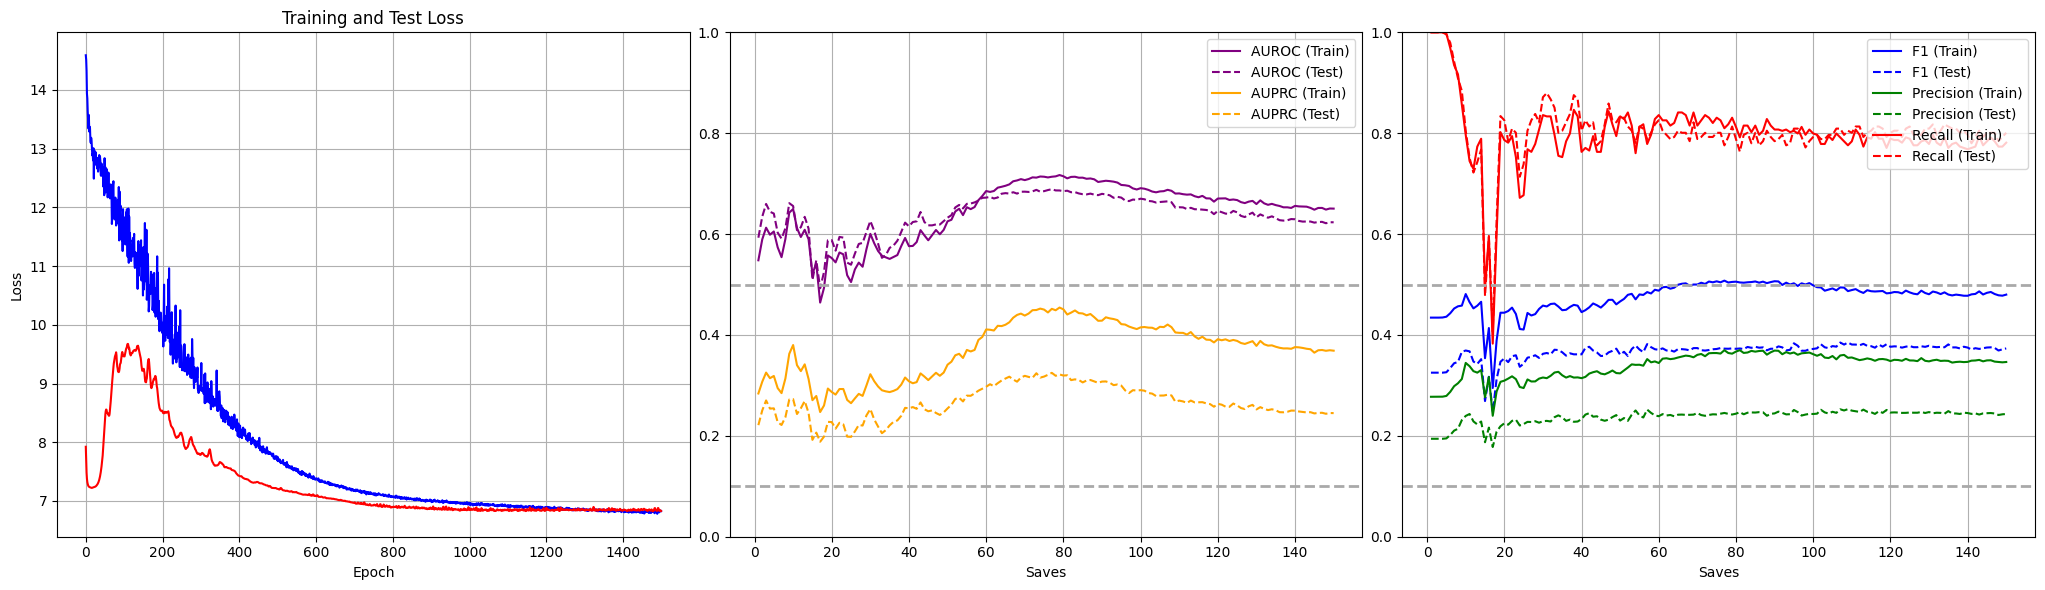

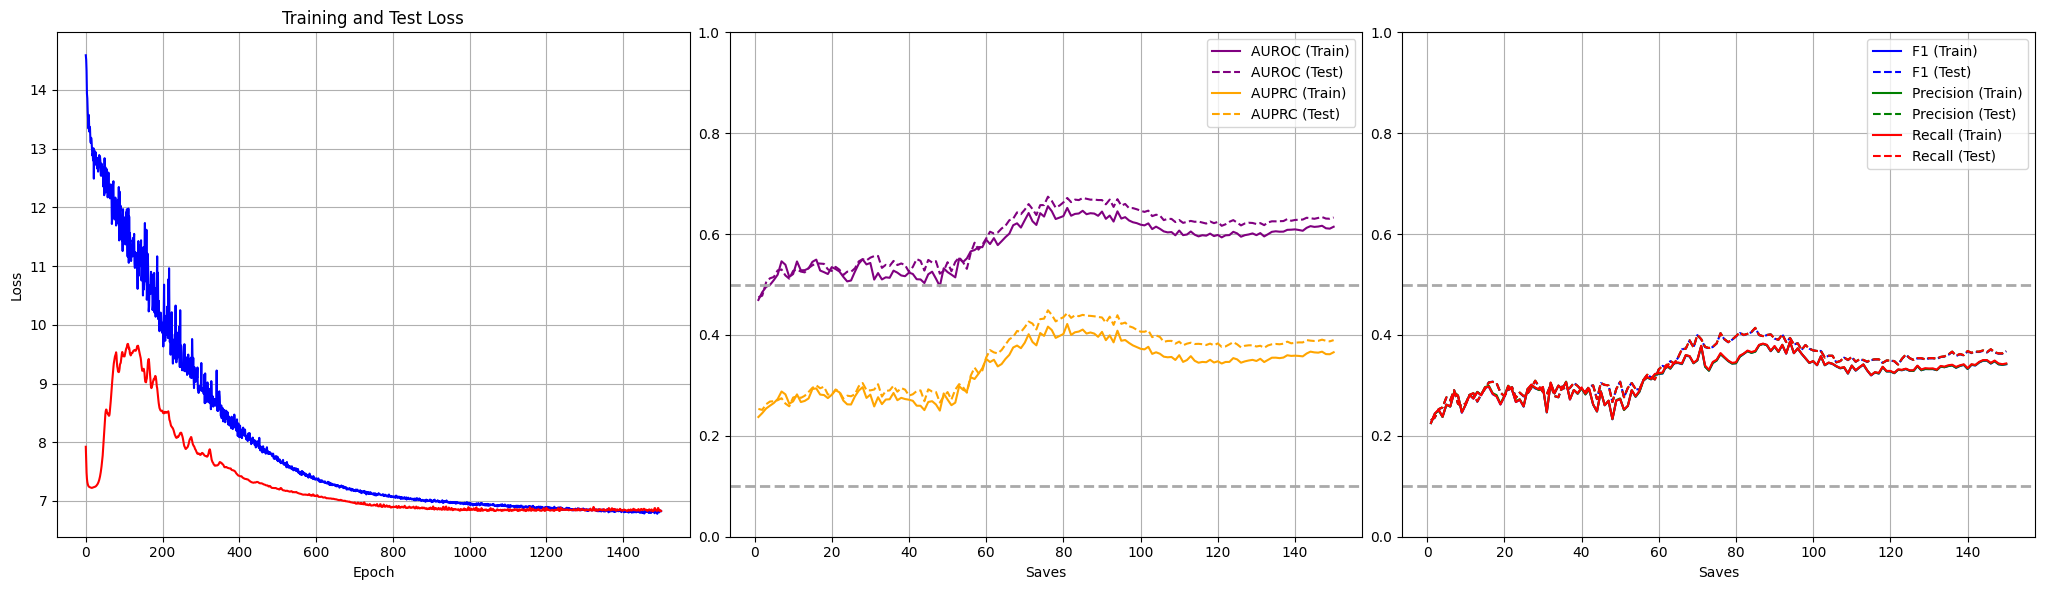

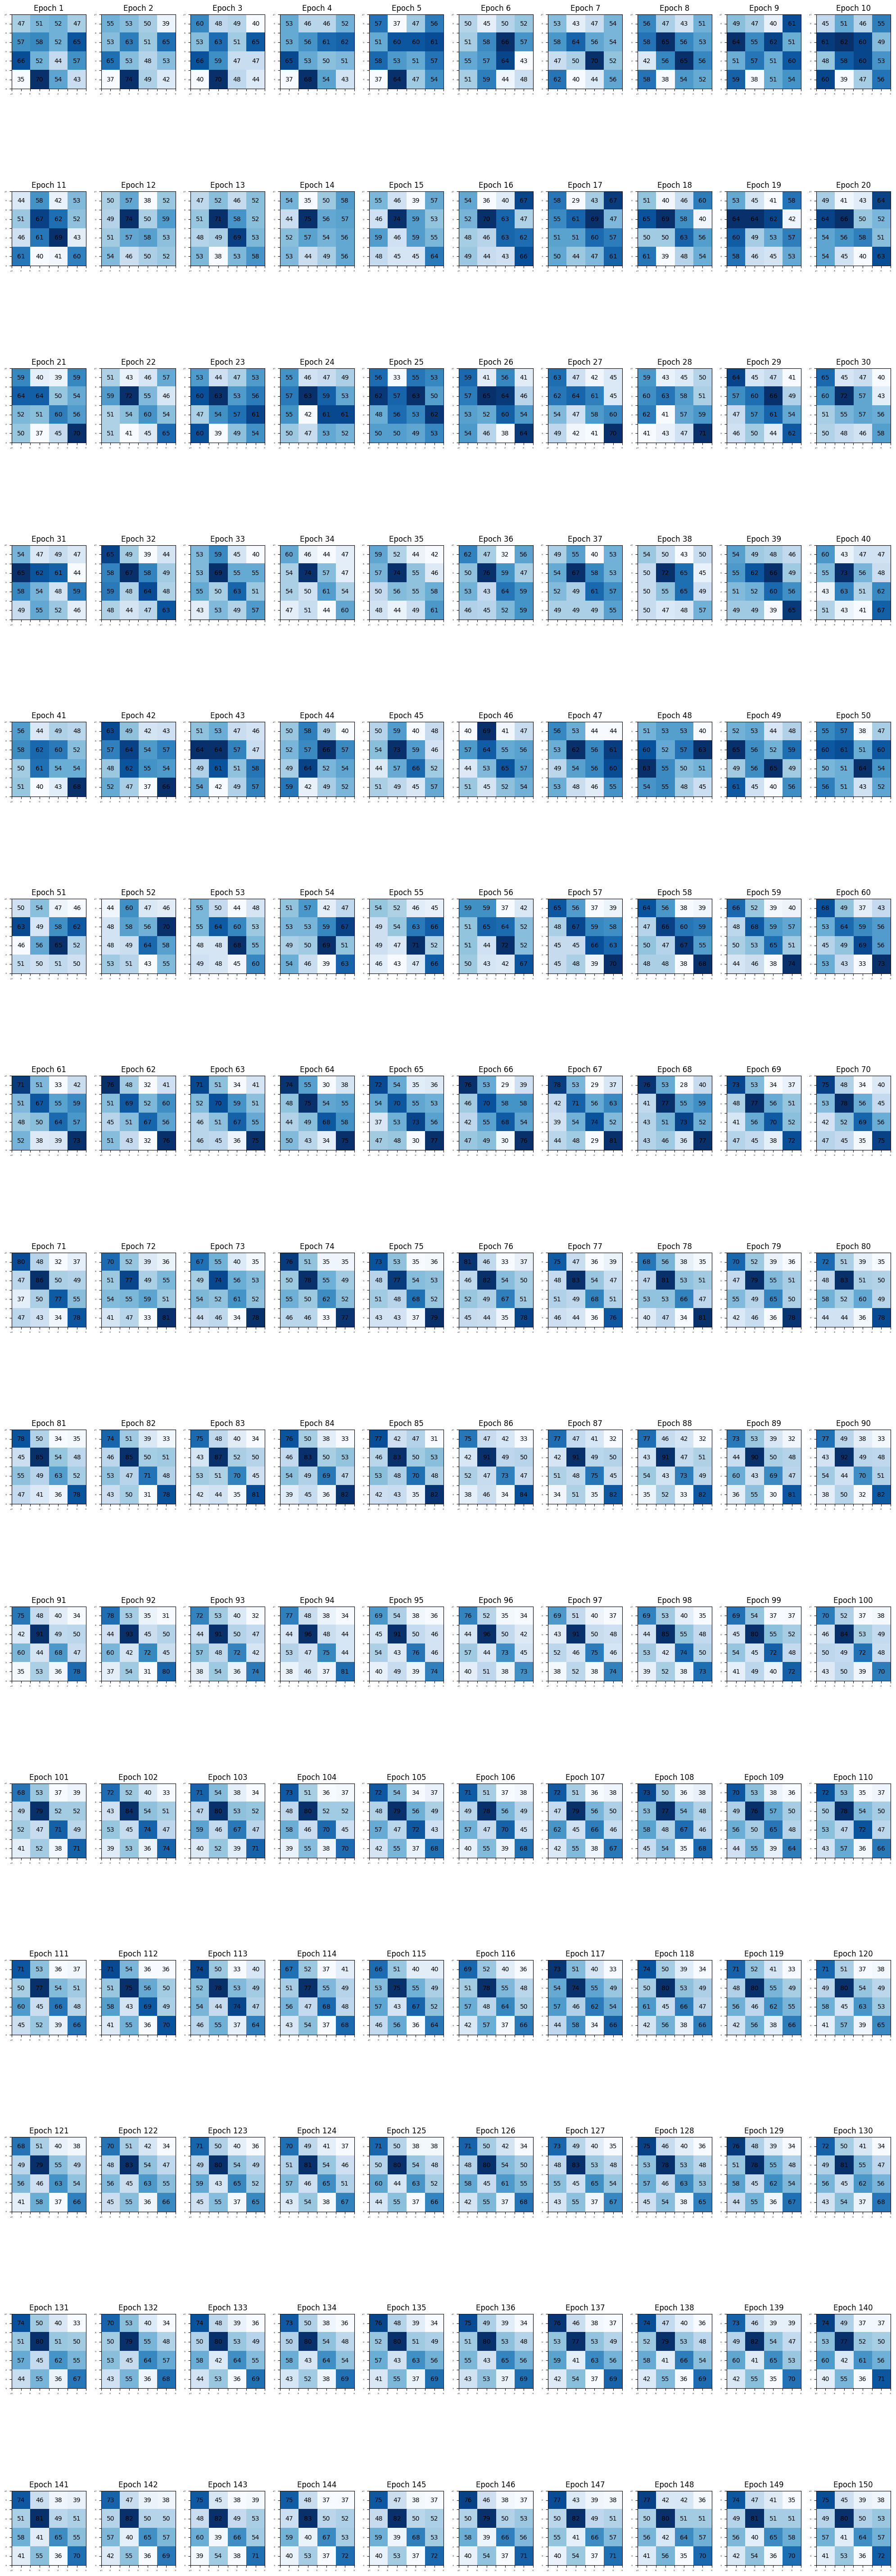

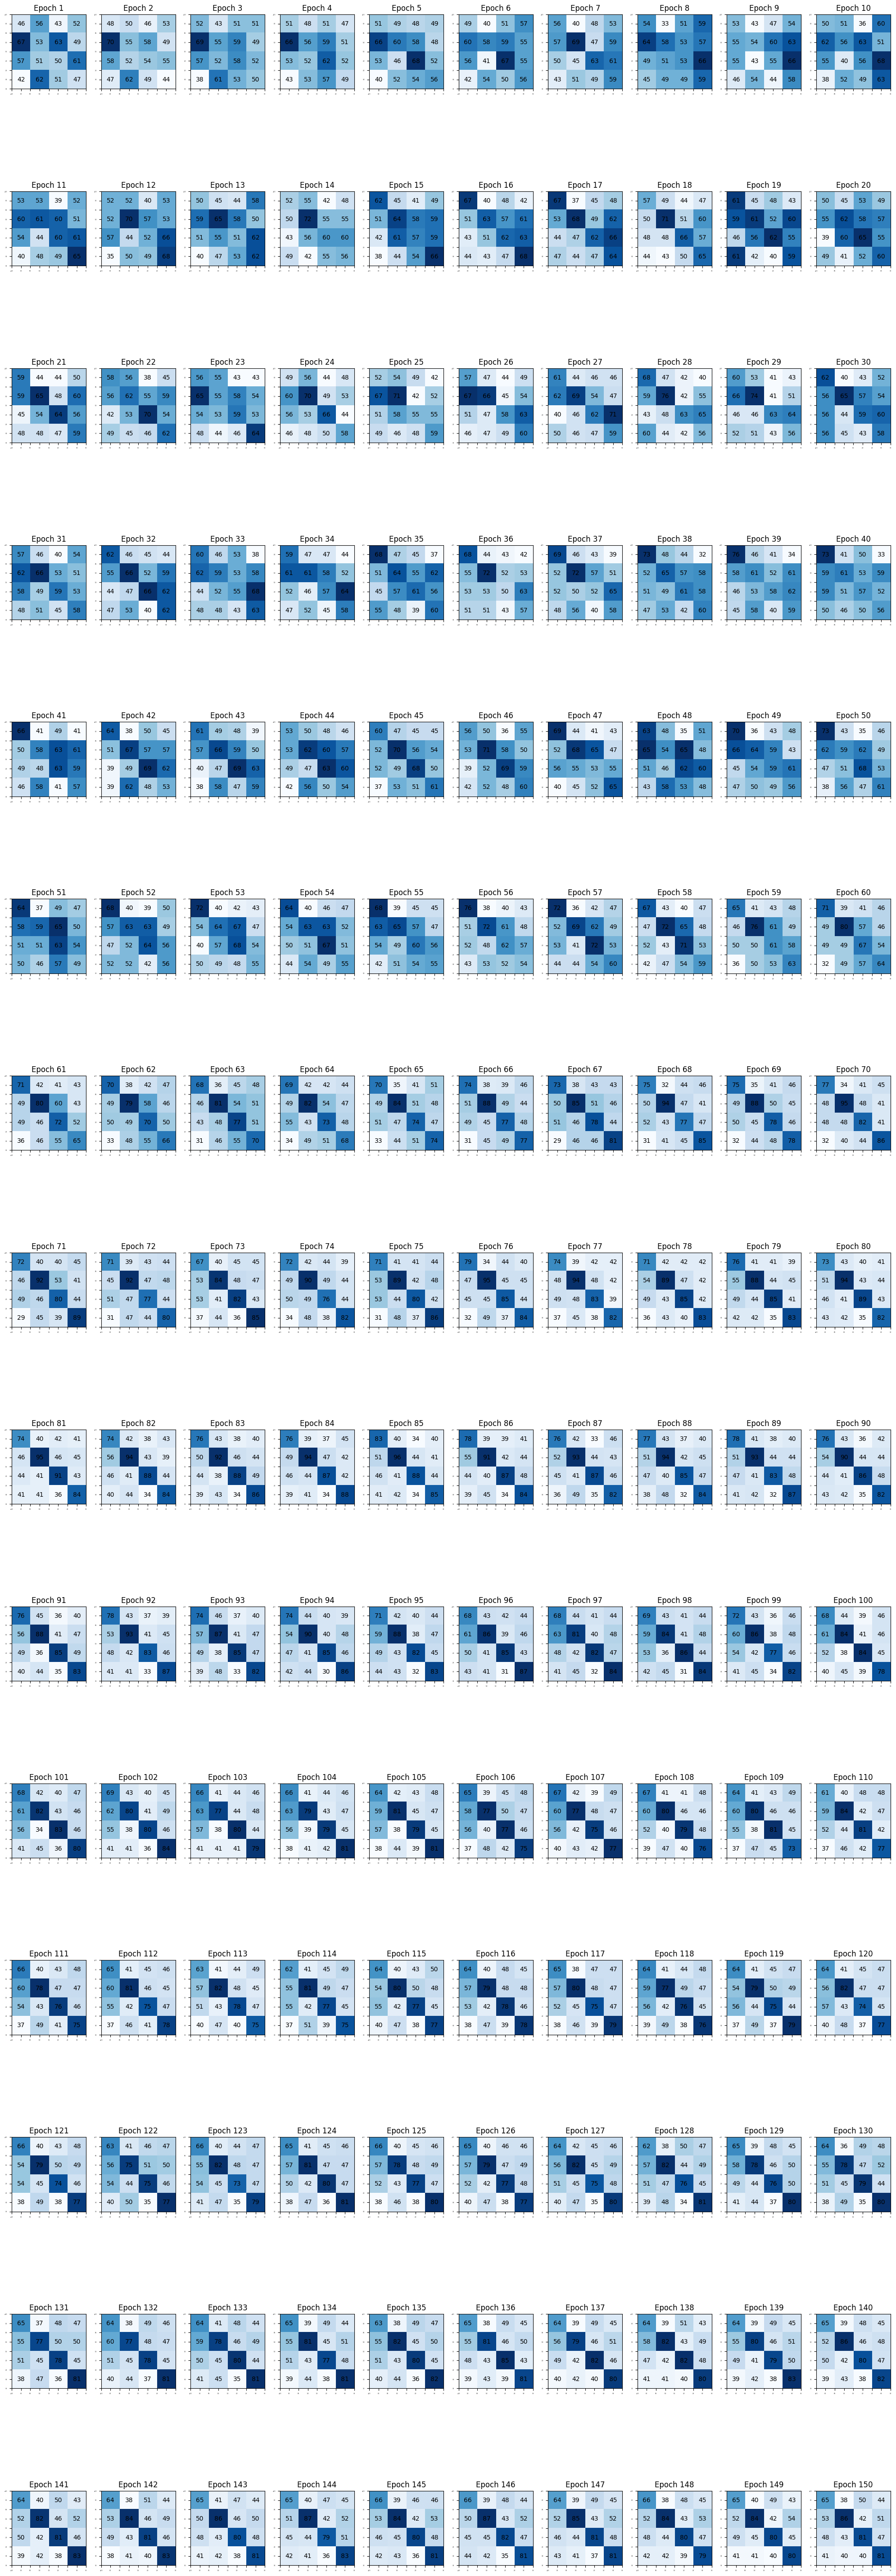

In [8]:
eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)